In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy import stats
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df = pd.read_csv("data_clean.csv", sep=",")
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Trip_Distance_km_log,Trip_Price_log
0,19.35000,Morning,Weekday,3.0,Low,Clear,3.560000,0.80,0.32,53.82,36.2600,3.013081,3.617920
1,47.59000,Afternoon,Weekday,1.0,High,Clear,3.500522,0.62,0.43,40.57,29.5058,3.883418,3.417917
2,36.87000,Evening,Weekend,1.0,High,Clear,2.700000,1.21,0.15,37.27,52.9000,3.634159,3.987130
3,30.33000,Evening,Weekday,4.0,Low,Clear,3.480000,0.51,0.15,116.81,36.4700,3.444576,3.623541
4,8.26455,Evening,Weekday,3.0,High,Clear,2.930000,0.63,0.32,22.64,15.6200,2.226195,2.810607


# Linear Model

In [3]:
# Create a copy to avoid modifying the original dataframe
df_model = df.copy()

# Drop the original non-log transformed columns
df_model = df_model.drop(['Trip_Distance_km', 'Trip_Price'], axis=1)

# Create dummy variables for categorical columns
categorical_columns = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']

# Create dummies and drop first category for each variable
for column in categorical_columns:
    dummies = pd.get_dummies(df_model[column], prefix=column, drop_first=True)
    df_model = pd.concat([df_model, dummies], axis=1)
    df_model = df_model.drop(column, axis=1)

df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Passenger_Count            983 non-null    float64
 1   Base_Fare                  983 non-null    float64
 2   Per_Km_Rate                983 non-null    float64
 3   Per_Minute_Rate            983 non-null    float64
 4   Trip_Duration_Minutes      983 non-null    float64
 5   Trip_Distance_km_log       983 non-null    float64
 6   Trip_Price_log             983 non-null    float64
 7   Time_of_Day_Evening        983 non-null    uint8  
 8   Time_of_Day_Morning        983 non-null    uint8  
 9   Time_of_Day_Night          983 non-null    uint8  
 10  Day_of_Week_Weekend        983 non-null    uint8  
 11  Traffic_Conditions_Low     983 non-null    uint8  
 12  Traffic_Conditions_Medium  983 non-null    uint8  
 13  Weather_Rain               983 non-null    uint8  

In [4]:
df_model.head()

,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Distance_km_log,Trip_Price_log,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekend,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Rain,Weather_Snow
0,3.0,3.560000,0.80,0.32,53.82,3.013081,3.617920,0,1,0,0,1,0,0,0
1,1.0,3.500522,0.62,0.43,40.57,3.883418,3.417917,0,0,0,0,0,0,0,0
2,1.0,2.700000,1.21,0.15,37.27,3.634159,3.987130,1,0,0,1,0,0,0,0
3,4.0,3.480000,0.51,0.15,116.81,3.444576,3.623541,1,0,0,0,1,0,0,0
4,3.0,2.930000,0.63,0.32,22.64,2.226195,2.810607,1,0,0,0,0,0,0,0


## Train and analyze linear regression model

In [5]:
# Scale numerical features only
numerical_columns = ['Trip_Distance_km_log', 'Passenger_Count', 'Base_Fare', 
                    'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price_log']

scaler = StandardScaler()
df_model_scaled = df_model.copy()
df_model_scaled[numerical_columns] = scaler.fit_transform(df_model_scaled[numerical_columns])

# Separate features and target
X = df_model_scaled.drop('Trip_Price_log', axis=1)
y = df_model_scaled['Trip_Price_log']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Add constant for statsmodels
X_train_sm = sm.add_constant(X_train)

# Fit the model
linear_model = sm.OLS(y_train, X_train_sm).fit()

# Print summary
print("\nModel Summary:")
print(linear_model.summary())


Model Summary:
                            OLS Regression Results                            
Dep. Variable:         Trip_Price_log   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     170.3
Date:                Thu, 23 Jan 2025   Prob (F-statistic):          1.07e-224
Time:                        19:55:57   Log-Likelihood:                -545.66
No. Observations:                 786   AIC:                             1121.
Df Residuals:                     771   BIC:                             1191.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const 

In [7]:
X_train_sm = X_train_sm.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

## Outliers

In [8]:
# Get influence measures
influence = linear_model.get_influence()
# Standardized residuals
standardized_residuals = influence.resid_studentized_internal
# Leverage (hat values)
leverage = influence.hat_matrix_diag
# Cook's distance
cooks_distance = influence.cooks_distance[0]
# DFFITS
dffits = influence.dffits[0]

# Create DataFrame with all metrics
diagnostics = pd.DataFrame({
    'Standardized_Residuals': standardized_residuals,
    'Leverage': leverage,
    'Cooks_Distance': cooks_distance,
    'DFFITS': dffits
})

In [9]:
diagnostics

,Standardized_Residuals,Leverage,Cooks_Distance,DFFITS
0,-3.042814,0.023140,0.014622,-0.470855
1,-0.169903,0.032782,0.000065,-0.031260
2,-0.079035,0.010119,0.000004,-0.007986
3,1.099652,0.030947,0.002574,0.196540
4,-0.517085,0.019664,0.000358,-0.073199
...,...,...,...,...
781,1.261205,0.040441,0.004469,0.259017
782,-0.327243,0.023434,0.000171,-0.050663
783,-0.658922,0.018954,0.000559,-0.091554
784,-0.660081,0.016415,0.000485,-0.085242


In [10]:
# Soglie
threshold_std_resid = 3
threshold_leverage = 2 * (X_train_sm.shape[1] + 1) / X_train_sm.shape[0]
threshold_cooks = 4 / X_train_sm.shape[0]
threshold_dffits = 2 * np.sqrt((X_train_sm.shape[1] + 1) / X_train_sm.shape[0])

# Identificare outlier
outliers = diagnostics[
    (diagnostics['Standardized_Residuals'].abs() > threshold_std_resid) |
    (diagnostics['Leverage'] > threshold_leverage) |
    (diagnostics['Cooks_Distance'] > threshold_cooks) |
    (diagnostics['DFFITS'].abs() > threshold_dffits)
]

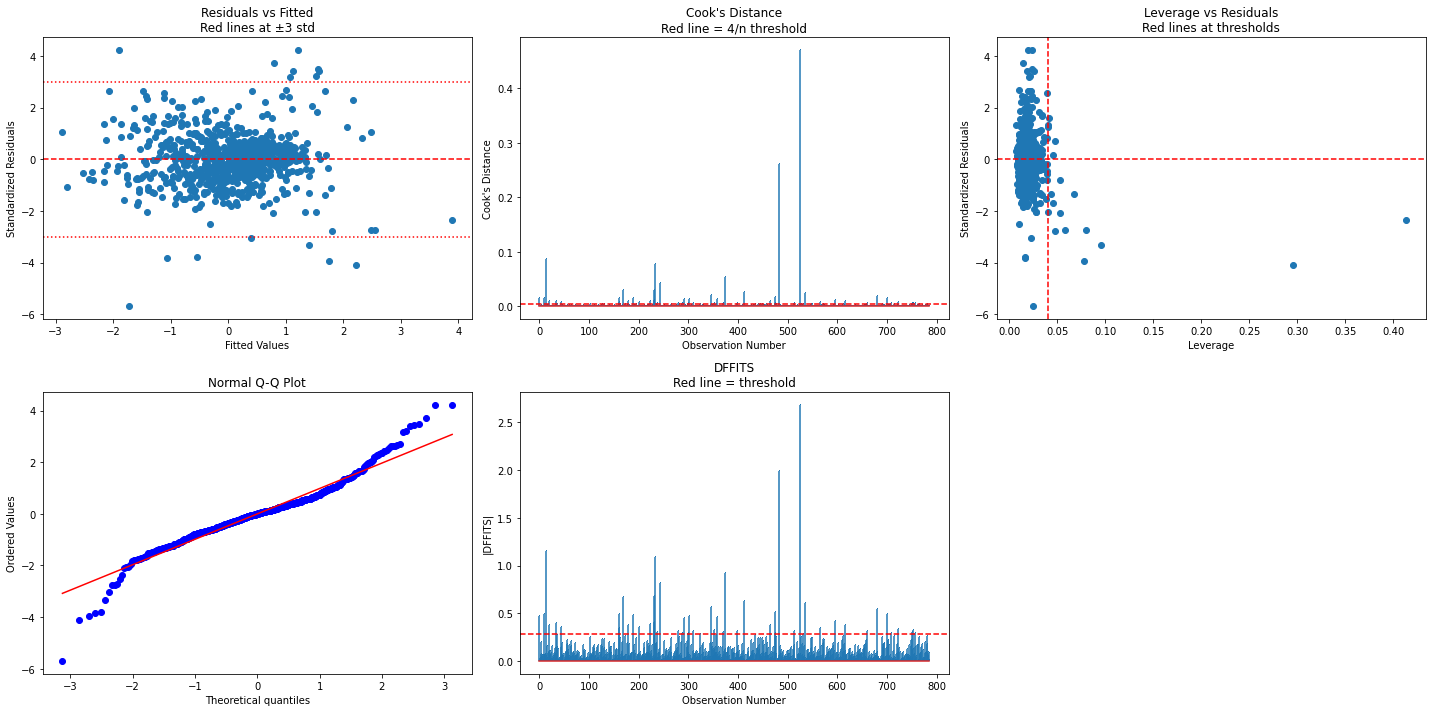

In [11]:
# Create diagnostic plots
fig = plt.figure(figsize=(20, 10))

# 1. Standardized Residuals vs Fitted Values
plt.subplot(231)
plt.scatter(linear_model.fittedvalues, standardized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=3, color='r', linestyle=':')
plt.axhline(y=-3, color='r', linestyle=':')
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
plt.title('Residuals vs Fitted\nRed lines at ±3 std')

# 2. Cook's Distance Plot
plt.subplot(232)
plt.stem(range(len(cooks_distance)), cooks_distance, markerfmt=',')
plt.axhline(y=threshold_cooks, color='r', linestyle='--')
plt.xlabel('Observation Number')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance\nRed line = 4/n threshold")

# 3. Leverage vs Standardized Residuals
plt.subplot(233)
plt.scatter(leverage, standardized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=threshold_leverage, color='r', linestyle='--')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Leverage vs Residuals\nRed lines at thresholds')

# 4. QQ Plot
plt.subplot(234)
stats.probplot(standardized_residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')

# 5. DFFITS Plot
plt.subplot(235)
plt.stem(range(len(dffits)), np.abs(dffits), markerfmt=',')
plt.axhline(y=threshold_dffits, color='r', linestyle='--')
plt.xlabel('Observation Number')
plt.ylabel('|DFFITS|')
plt.title('DFFITS\nRed line = threshold')

plt.tight_layout()
plt.show()

In [12]:
# Delete outliers
X_train_sm = X_train_sm.drop(index = outliers.index.tolist())
y_train = y_train.drop(index = outliers.index.tolist())

In [13]:
# Fit the model
linear_model = sm.OLS(y_train, X_train_sm).fit()

# Print summary
print("\nModel Summary:")
print(linear_model.summary())


Model Summary:
                            OLS Regression Results                            
Dep. Variable:         Trip_Price_log   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     347.1
Date:                Thu, 23 Jan 2025   Prob (F-statistic):          5.87e-308
Time:                        19:56:01   Log-Likelihood:                -198.34
No. Observations:                 732   AIC:                             426.7
Df Residuals:                     717   BIC:                             495.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const 

## Evaluate model predictions

In [14]:
# Add constant for prediction
X_test_sm = sm.add_constant(X_test)

# Make predictions
y_pred = linear_model.predict(X_test_sm)

# Calculate metrics
mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
r2 = linear_model.rsquared

# Calculate metrics on actual price scale
actual_prices = np.exp(y_test)
predicted_prices = np.exp(y_pred)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")


Model Performance Metrics:
Mean Squared Error: 0.2633
Root Mean Squared Error: 0.5131
R-squared: 0.8714
Mean Absolute Percentage Error: 36.13%


## Diagnostic plots for linear regression

In [15]:
# Get residuals and fitted values
residuals = linear_model.resid
fitted_values = linear_model.fittedvalues

Text(0.5, 1.0, 'Residuals vs Fitted Values\n(Check for Linearity and Homoscedasticity)')

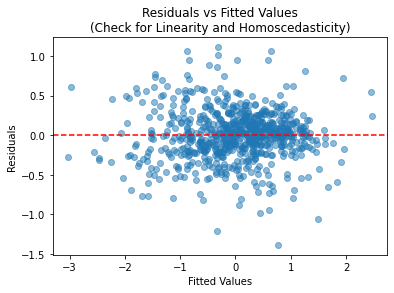

In [16]:
# 1. Residuals vs Fitted Values
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values\n(Check for Linearity and Homoscedasticity)')

Text(0.5, 1.0, 'Q-Q Plot\n(Check for Normality of Residuals)')

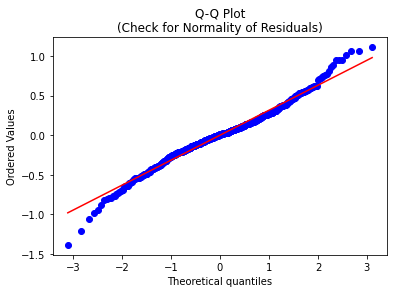

In [17]:
# 2. Q-Q Plot for Normality
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot\n(Check for Normality of Residuals)')

Text(0.5, 1.0, 'Histogram of Residuals\n(Check for Normality)')

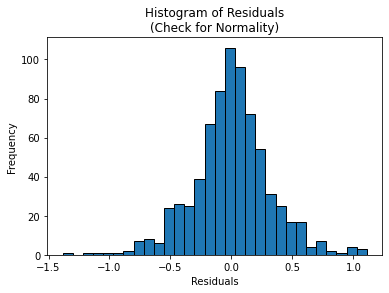

In [18]:
# 3. Residuals Histogram
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals\n(Check for Normality)')

Text(0.5, 1.0, 'Correlation Heatmap\n(Check for Multicollinearity)')

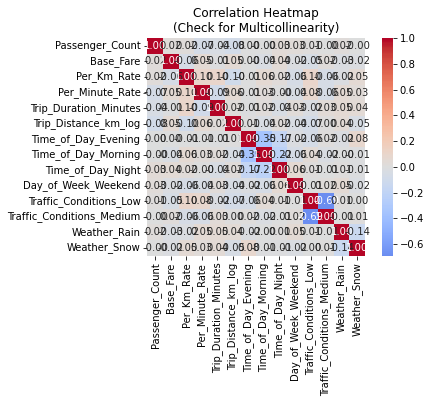

In [19]:
# 4. Correlation Heatmap
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=True, fmt='.2f', square=True)
plt.title('Correlation Heatmap\n(Check for Multicollinearity)')

# Best subset selection

In [22]:
X_train_sm.drop('const', axis=1)

n_features = X_train_sm.shape[1]

best_models = {}

for k in range(1, n_features + 1):
    best_score = -np.inf
    best_combo = None
    best_model = None

    # Get all possible combinations of k features
    for combo in combinations(range(n_features), k):
        # Get the features for this combination
        X_subset = X_train_sm.iloc[:, list(combo)]

        # Add constant
        X_subset = sm.add_constant(X_subset)

        # Fit model
        model = sm.OLS(y_train, X_subset).fit()

        # Calculate adjusted R-squared
        score = model.rsquared_adj

        if score > best_score:
            best_score = score
            best_combo = combo
            best_model = model

    # Store best model for this number of features
    best_models[k] = {
        'features': [X_train_sm.columns[i] for i in best_combo],
        'model': best_model,
        'adj_r2': best_score,
        'aic': best_model.aic,
        'bic': best_model.bic
    }

    print(f"\nBest model with {k} features:")
    print(f"Features: {best_models[k]['features']}")
    print(f"Adjusted R-squared: {best_score:.4f}")
    print(f"AIC: {best_model.aic:.4f}")
    print(f"BIC: {best_model.bic:.4f}")


Best model with 1 features:
Features: ['Trip_Distance_km_log']
Adjusted R-squared: 0.5203
AIC: 1363.5082
BIC: 1372.6997

Best model with 2 features:
Features: ['Per_Km_Rate', 'Trip_Distance_km_log']
Adjusted R-squared: 0.7066
AIC: 1004.5488
BIC: 1018.3362

Best model with 3 features:
Features: ['Per_Km_Rate', 'Trip_Duration_Minutes', 'Trip_Distance_km_log']
Adjusted R-squared: 0.8124
AIC: 678.0962
BIC: 696.4794

Best model with 4 features:
Features: ['Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Distance_km_log']
Adjusted R-squared: 0.8625
AIC: 452.0006
BIC: 474.9795

Best model with 5 features:
Features: ['Passenger_Count', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Distance_km_log']
Adjusted R-squared: 0.8688
AIC: 418.5802
BIC: 446.1549

Best model with 6 features:
Features: ['Passenger_Count', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Distance_km_log', 'Day_of_Week_Weekend']
Adjusted R-squared: 0.8693
AIC: 416.8164
BIC

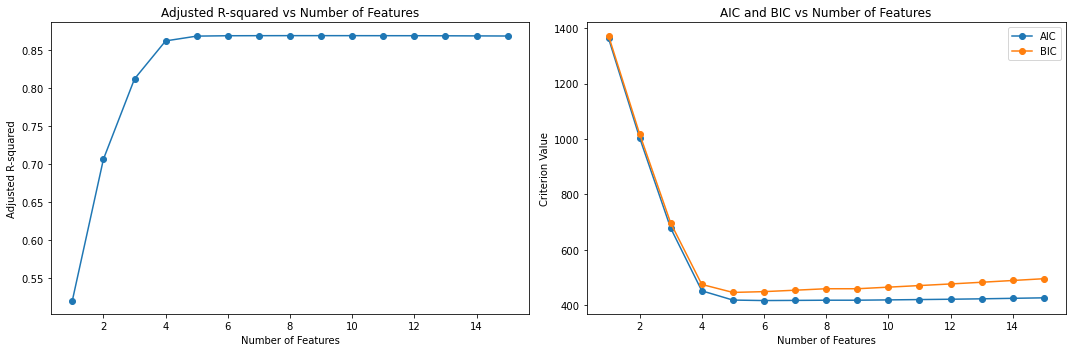

In [23]:
n_features = list(best_models.keys())
adj_r2 = [model['adj_r2'] for model in best_models.values()]
aic = [model['aic'] for model in best_models.values()]
bic = [model['bic'] for model in best_models.values()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Adjusted R-squared
ax1.plot(n_features, adj_r2, marker='o')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('Adjusted R-squared')
ax1.set_title('Adjusted R-squared vs Number of Features')

# Plot AIC and BIC
ax2.plot(n_features, aic, marker='o', label='AIC')
ax2.plot(n_features, bic, marker='o', label='BIC')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Criterion Value')
ax2.set_title('AIC and BIC vs Number of Features')
ax2.legend()

plt.tight_layout()
plt.show()

In [24]:
print(best_models[3]['model'].summary())

                            OLS Regression Results                            
Dep. Variable:         Trip_Price_log   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     1056.
Date:                Thu, 23 Jan 2025   Prob (F-statistic):          1.17e-264
Time:                        20:09:30   Log-Likelihood:                -335.05
No. Observations:                 732   AIC:                             678.1
Df Residuals:                     728   BIC:                             696.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.01

In [25]:
# The best model
best_bic = float('inf')
best_k = None

for k, model_info in best_models.items():
    if model_info['bic'] < best_bic:
        best_bic = model_info['bic']
        best_k = k
    
best_k

5